In [1]:
!pip install -r requirements.txt;
!pip install matplotlib;

In [2]:
Bukidnon_Data = '1z35Kyga40hhoGBEQIY9jReY6z1wmnsnlUVw-pFEaBhg'

In [3]:
# import input dataset
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# quantities of food items
q = read_sheets(Bukidnon_Data,sheet='Quantities')
q.replace(0, np.nan, inplace=True)
q.set_index(['i', 't', 'm'], inplace=True)

# food expenditure
x = read_sheets(Bukidnon_Data,sheet='Expenditures')
x.columns.name = 'j'
# household characteristics
d = read_sheets(Bukidnon_Data,sheet="HH Characteristics")

# keep a copy
d_copy = d

# x may have duplicate columns
x = x.groupby('j',axis=1).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x.set_index(['i','t','m']))

fct_data = '1TqKea-3Jf_2P0VsStRP7bT9A1Vk1TiVSDulAHyuRYkE'
# fct
fct = read_sheets(fct_data,sheet="FCT")
fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))
fct = fct.fillna(0)

# rdi
rdi = pd.read_csv("rdi.csv")
rdi = rdi.set_index('Nutrition')
rdi.columns.name = 'k'

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


In [4]:
# read in additional data from the Bukidnon survey

# major crop production
import pandas as pd
crops = pd.read_stata('b3m.dta')

crops = crops[crops.m4a != 'Crop to be harvested']
crops = crops[crops.m4a != 'Sold as a standing crop']
crops = crops[crops.m4a != 'Dont Know']

crops = crops[crops['m4b'].str.contains("Ton|Kilo")==True]

# construct variables: production of sugar, rice, yellow corn, white corn, rubber, and coconut, in kilograms
variables = ['Sugar', 'Rice', 'Yellow Corn', 'White Corn', 'Rubber', 'Coconut']

# construct hh characteristic tables, each for one additional variable
tables = []

for v in variables:
    crops[v] = np.where(crops['m2'] == v, crops['m4a'], 0)
    # convert unit from ton to kilogram
    crops[v] = crops[v].astype('float')
    crops.loc[crops["m4b"] == "Ton", v] = crops[v] * 1000  
    
    
    tmp = crops[["hhid",v]]
    # sum all production by the same household
    tmp = tmp.groupby("hhid").sum()
    # log transformation, add a constant to avoid log(0)
    tmp[v] = np.log(tmp[v] + 1)
    name = 'log' + v
    tmp = tmp.rename(columns={v:name})
    # merge with the HH characteristics dataframe 
    d = d.merge(tmp[name], left_on='i', right_on='hhid')
    t = d_copy.merge(tmp[name], left_on='i', right_on='hhid')
    tables.append(t)



In [5]:
# land ownership
parcel = pd.read_stata('b3ka.dta')

# construct variable: area of land owned by household AND cultivated during the past 12 months

#print(parcel["ka5a"].value_counts())
#print(parcel.loc[parcel["ka5b"] == "Square meters", "ka5a"])

# convert unit - 1 square meter = 0.0001 hectare
parcel.loc[parcel["ka5b"] == "Square meters", "ka5a"] = parcel["ka5a"] * 0.0001

#print(parcel["ka5a"].value_counts())
#print(parcel.loc[parcel["ka5b"] == "Square meters", "ka5a"])
land_area = parcel[["hhid","ka5a"]]
# sum all parcels of land owned by the same household
land_area = land_area.groupby("hhid").sum()
# rename the column
land_area = land_area.rename(columns={"ka5a":"Land Area"})
# log transformation
land_area['logLand Area'] = np.log(land_area["Land Area"] + 1)
# merge with the HH characteristics dataframe 
d = d.merge(land_area['logLand Area'], left_on='i', right_on='hhid')
t = d_copy.merge(land_area['logLand Area'], left_on='i', right_on='hhid')
tables.append(t)

In [6]:
# shocks
shocks = pd.read_stata('b3f.dta')

# construct variable: whether experienced negative shocks (1=yes, 0=no)

# recode
shocks["f0"] = np.where(shocks["f0"] == "Yes", 1, 0)
#shocks.loc[shocks["f0"] == "No", "f0"] = 0

shocks = shocks[["hhid","f0"]]

shocks = shocks.groupby("hhid").sum()
# rename the column
shocks = shocks.rename(columns={"f0":"Had Shocks"})
#shocks['hhid']
# merge with the HH characteristics dataframe 
d = d.merge(shocks["Had Shocks"], left_on='i', right_on='hhid')
t = d_copy.merge(shocks["Had Shocks"], left_on='i', right_on='hhid')
tables.append(t)

In [7]:
from cfe.estimation import drop_columns_wo_covariance

y = drop_columns_wo_covariance(y,min_obs=30)
y_copy = y
# set indices
d.columns.name = 'k'
d.set_index(['i','t','m'],inplace=True)
use = y.index.intersection(d.index)
y = y.loc[use,:]
d = d.loc[use,:]
d_copy2 = d
d_copy3 = d
y = y.stack()

d = d.stack()

# Check that indices are in right places!
assert y.index.names == ['i','t','m','j']
assert d.index.names == ['i','t','m','k']

Missing dependencies for OracleDemands.


In [8]:
# run regressions with each additional variable
from cfe import Regression

results = []
for t in tables:
    t.columns.name = 'k'
    t.set_index(['i','t','m'],inplace=True)
    y_tmp = y_copy
    use = y_tmp.index.intersection(t.index)
    y_tmp = y_tmp.loc[use,:]
    t = t.loc[use,:]
    y_tmp = y_tmp.stack()
    t = t.stack()
    assert y_tmp.index.names == ['i','t','m','j']
    assert t.index.names == ['i','t','m','k']
    r = Regression(y=y_tmp,d=t)
    results.append(r)

In [9]:
# regression tables stored in the list gamma_tables
gamma_tables = []
for r in results:
    r.get_predicted_log_expenditures()
    gamma_tables.append(r.gamma)

In [10]:
# access regression results for each additional variable
# log sugar production
gamma_tables[0]

k,Males 0-1,Males 1-5,Males 5-10,Males 10-15,Males 15-20,Males 20-30,Males 30-50,Males 50-60,Males 60-100,Females 0-1,...,Females 5-10,Females 10-15,Females 15-20,Females 20-30,Females 30-50,Females 50-60,Females 60-100,log HSize,logSugar,Constant
j,,,,,,,,,,,,,,,,,,,,,
Alcoholic drinks,0.186454,0.235887,-0.024436,-0.332314,0.146236,0.116782,0.170338,-0.194779,-0.355880,-0.731840,...,-0.044418,-0.000264,0.035271,0.045711,0.055517,0.017554,-0.198813,0.140197,0.010488,-0.508087
Ampalaya,0.218503,0.349025,0.373874,0.325913,0.316649,0.309380,0.148764,0.287838,0.186355,-0.703101,...,0.449113,0.290667,0.204971,0.074488,0.182354,0.239365,0.441703,-1.571566,0.028575,0.933104
Atsal,0.159256,0.157163,0.333897,-0.052803,0.119034,0.187153,0.057564,0.466070,0.110448,-0.023106,...,0.419571,0.051372,-0.072309,0.170648,0.106301,0.037768,-0.052744,-0.784967,0.026055,0.368586
Bagoong,0.290594,0.174162,0.025187,-0.052654,0.064839,0.077081,0.062148,0.284051,0.176713,-0.407197,...,0.147018,0.089949,0.161450,-0.090814,0.034654,-0.005181,-0.238615,0.205278,0.008028,-0.765388
Banana,0.141880,0.169443,0.410879,0.236230,-0.011163,0.044373,-0.115739,0.451424,0.465698,-0.100427,...,0.394070,-0.054260,0.218373,-0.091278,0.413165,0.176426,0.269686,-0.782217,0.035273,0.130765
Beef,-0.185793,-0.096333,0.143558,-0.005566,-0.120673,0.059518,0.164727,0.388178,-0.003021,-0.529260,...,-0.069848,0.122198,-0.105512,-0.046230,-0.014444,-0.084028,-0.419617,0.055462,0.046119,-0.656188
Calamansi,-0.285530,0.024311,0.295892,0.085590,0.177645,0.006081,0.004654,-0.382434,0.086777,0.005458,...,0.019574,0.252882,0.226100,0.120206,0.234564,0.460279,0.237625,-0.847527,0.048762,0.450101
Carrots,0.081957,0.139651,-0.297102,0.012801,0.105035,-0.050101,-0.019959,-0.233750,0.010173,-0.696009,...,-0.056943,0.103994,0.120360,0.099146,0.268826,0.462687,-0.066174,-0.126432,-0.015698,-0.324086
Chicken,0.081981,-0.110425,0.267750,-0.194989,-0.105188,-0.032697,-0.058575,0.020461,-0.064565,-0.516255,...,0.168459,-0.330313,-0.113645,0.094389,-0.168052,-0.089233,0.046045,1.181824,0.008030,-1.995812


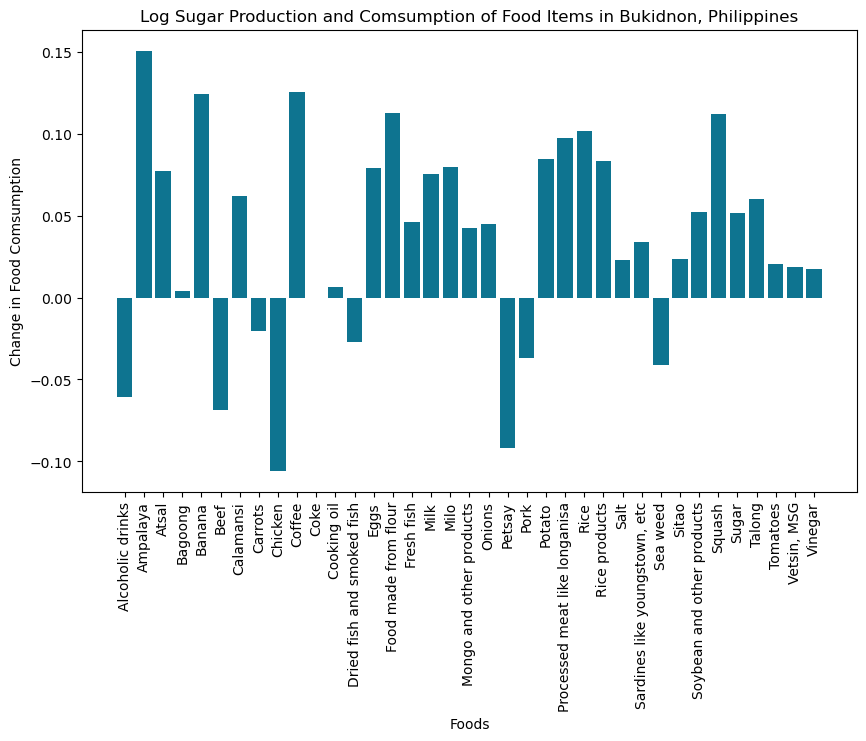

In [11]:
# Create a bar chart for log sugar production
def plot_gamma_table(gamma_table, variable_name):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Take the mean across the second dimension of the gamma table values array
    mean_values = gamma_table.values.mean(axis=1)

    ax.bar(gamma_table.index, mean_values, color='#0e7490')
    ax.set_title(f'Log {variable_name} Production and Comsumption of Food Items in Bukidnon, Philippines')
    ax.set_xlabel('Foods')
    ax.set_ylabel('Change in Food Comsumption')
    plt.xticks(rotation=90)
    plt.show()

    
# Plot the gamma table for log sugar production
plot_gamma_table(gamma_tables[0], 'Sugar')

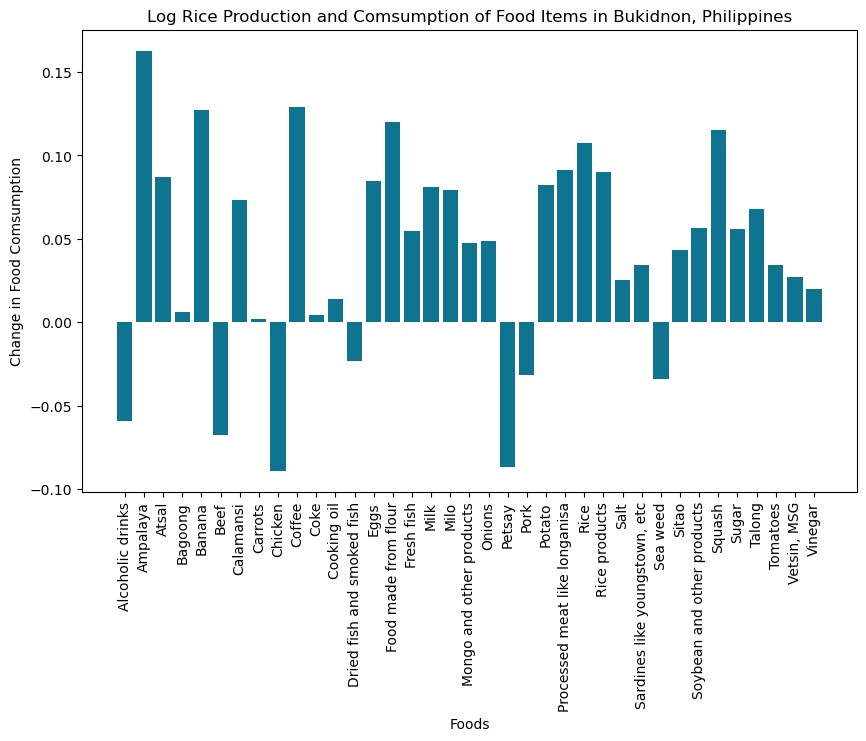

In [12]:
# Plot the gamma table for log rice production
plot_gamma_table(gamma_tables[1], 'Rice')

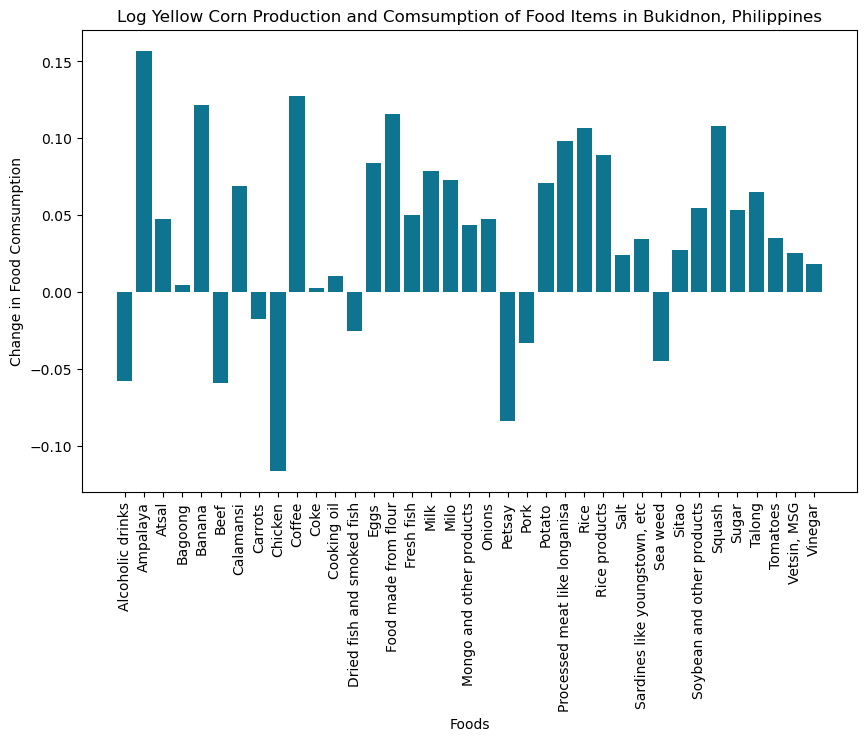

In [13]:
# Plot the gamma table for log yellow corn production
plot_gamma_table(gamma_tables[2], 'Yellow Corn')

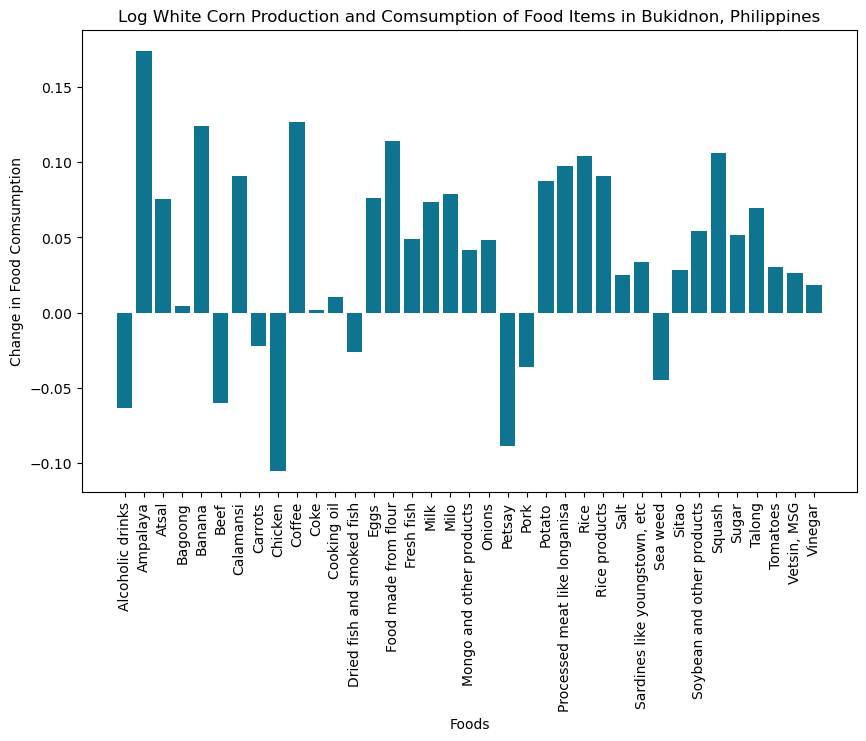

In [14]:
# Plot the gamma table for log white corn production
plot_gamma_table(gamma_tables[3], 'White Corn')

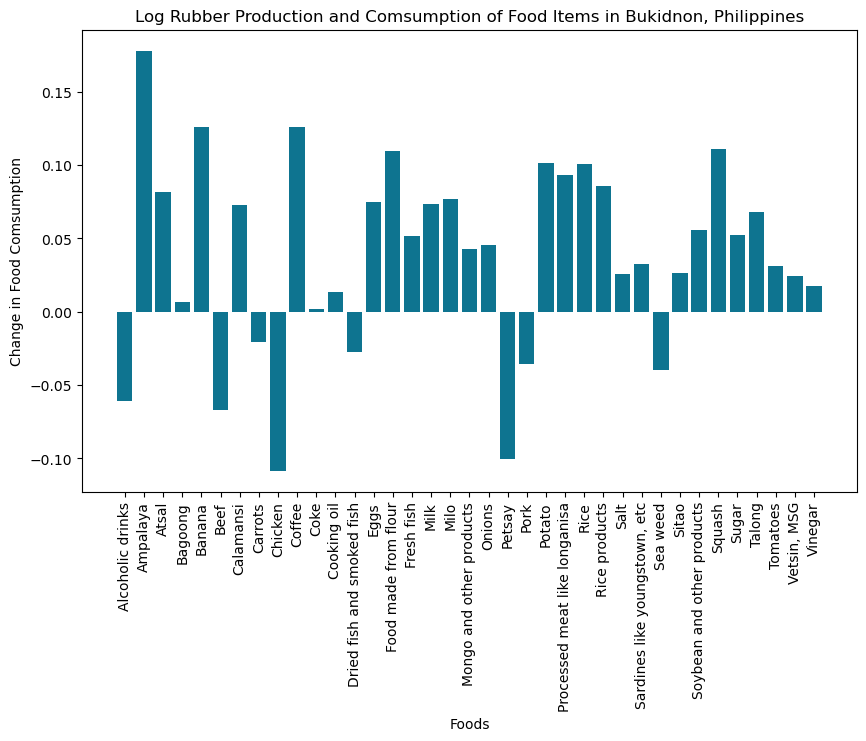

In [15]:
# Plot the gamma table for log rubber production
plot_gamma_table(gamma_tables[4], 'Rubber')

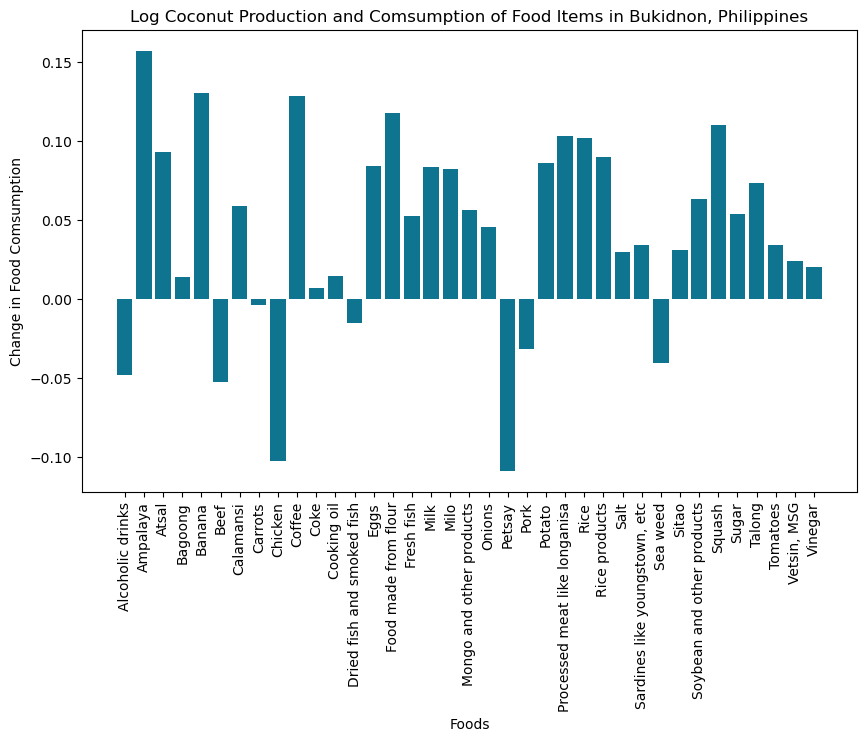

In [16]:
# Plot the gamma table for log coconut production
plot_gamma_table(gamma_tables[5], 'Coconut')

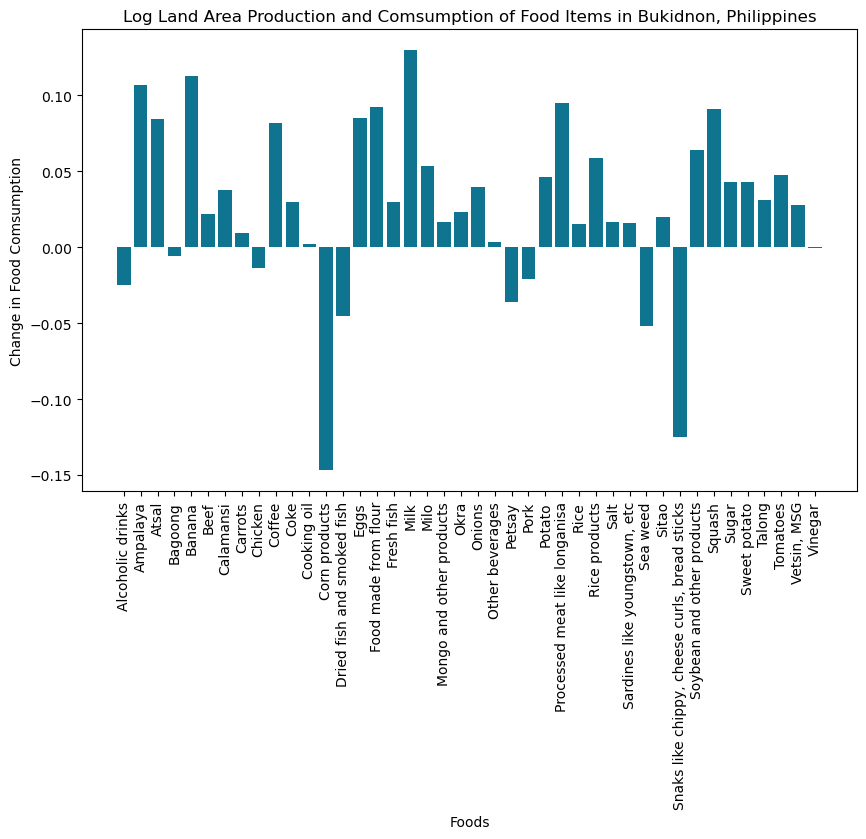

In [17]:
# Plot the gamma table for log land area
plot_gamma_table(gamma_tables[6], 'Land Area')

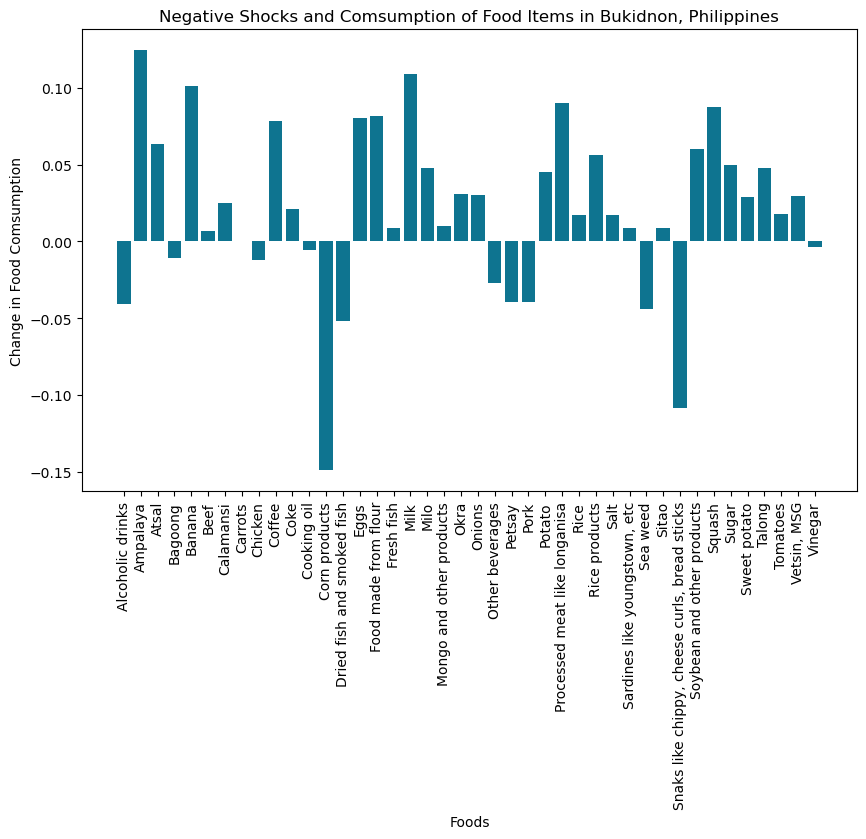

In [18]:
# Plot the gamma table for shocks
gamma_table = gamma_tables[7]
fig, ax = plt.subplots(figsize=(10, 6))

# Take the mean across the second dimension of the gamma table values array
mean_values = gamma_table.values.mean(axis=1)

ax.bar(gamma_table.index, mean_values, color='#0e7490')
ax.set_title('Negative Shocks and Comsumption of Food Items in Bukidnon, Philippines')
ax.set_xlabel('Foods')
ax.set_ylabel('Change in Food Comsumption')
plt.xticks(rotation=90)
plt.show()

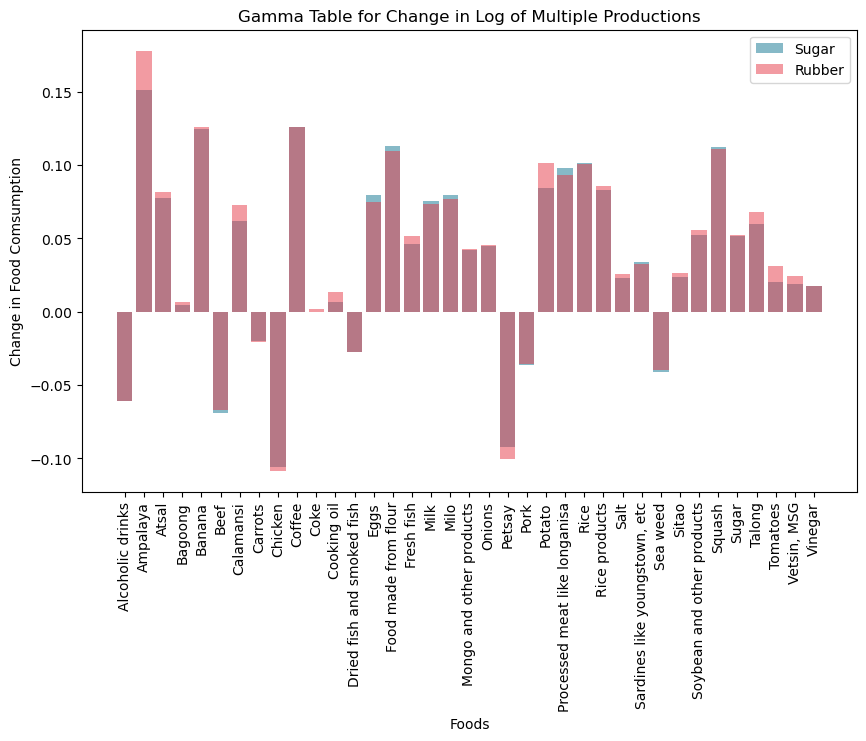

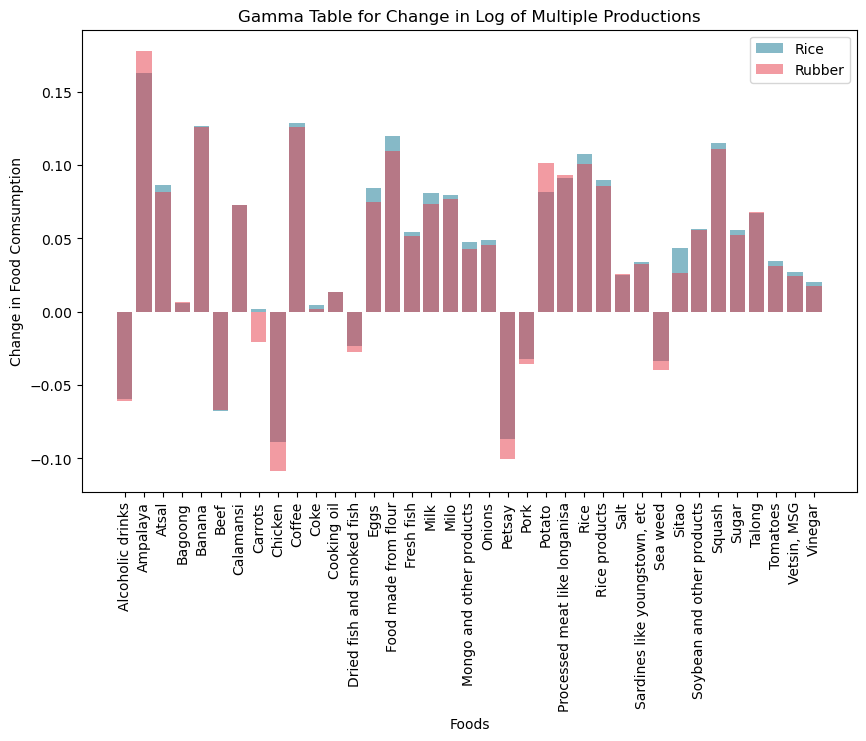

In [19]:
def plot_multiple_gamma_tables(gamma_tables, variable_names):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Set the common labels and title
    ax.set_title('Gamma Table for Change in Log of Multiple Productions')
    ax.set_xlabel('Foods')
    ax.set_ylabel('Change in Food Comsumption')
    plt.xticks(rotation=90)

    # Define colors for each production variable
    colors = ['#0e7490', '#e63946', '#f1c40f']

    for i, (gamma_table, variable_name) in enumerate(zip(gamma_tables, variable_names)):
        # Take the mean across the second dimension of the gamma table values array
        mean_values = gamma_table.values.mean(axis=1)
        
        # Create the bars with lowered opacity (alpha) and label them
        ax.bar(gamma_table.index, mean_values, color=colors[i % len(colors)], alpha=0.5, label=variable_name)

    # Add a legend to the graph
    ax.legend()
    plt.show()

plot_multiple_gamma_tables([gamma_tables[0], gamma_tables[4]], ['Sugar','Rubber'])
plot_multiple_gamma_tables([gamma_tables[1], gamma_tables[4]], ['Rice','Rubber'])

In [20]:
# regression with all variables
result = Regression(y=y,d=d)
x_hat = result.predicted_expenditures().unstack(level=3)
x_hat.reset_index(inplace=True)
x_hat.set_index(['i', 't', 'm'], inplace=True)
x_hat

,,j,Alcoholic drinks,Ampalaya,Atsal,Bagoong,Banana,Beef,Calamansi,Carrots,Chicken,Coffee,...,"Sardines like youngstown, etc",Sea weed,Sitao,Soybean and other products,Squash,Sugar,Talong,Tomatoes,"Vetsin, MSG",Vinegar
i,t,m,,,,,,,,,,,,,,,,,,,,,
2,2003,Bukidnon,8.837490,5.595471,5.763640,5.069240,30.376846,35.034891,13.705852,3.473736,60.633610,12.947293,...,12.888622,3.199094,15.429875,11.326157,4.729369,20.444168,16.783744,10.592812,6.363250,3.973340
4,2003,Bukidnon,59.611765,9.297498,16.604706,13.661939,29.156999,64.016258,4.228126,10.445394,74.300178,21.314257,...,29.365874,20.931682,8.471014,12.858778,13.405974,20.727400,19.429854,10.484085,7.102215,4.535600
6,2003,Bukidnon,94.707909,20.001961,20.037246,15.783777,36.019099,48.454684,14.960442,18.306095,105.429020,18.224108,...,61.447568,33.582734,10.513327,12.354725,13.675117,29.163505,28.732952,20.532418,8.311588,6.437665
12,2003,Bukidnon,86.396601,14.663271,10.518822,25.172667,8.054236,30.716561,3.779851,8.201916,177.979767,11.884390,...,28.089876,10.895167,7.686834,12.558522,6.569750,26.073781,17.220798,3.551033,12.729370,10.562458
14,2003,Bukidnon,15.358105,7.073477,1.886139,5.134579,8.729939,14.991047,4.395172,6.379522,46.070030,7.189100,...,10.007797,7.096854,4.810424,5.395753,3.947421,13.329483,7.930455,2.487661,4.673551,3.026555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,2003,Bukidnon,46.713707,14.757984,10.904599,12.433247,33.712963,108.577788,12.276025,5.314681,88.480157,18.570486,...,27.604151,9.283627,9.620937,13.994648,4.601325,26.245815,19.705316,8.320748,7.731092,2.852023
935,2003,Bukidnon,29.754797,14.079980,16.629917,12.220452,22.294530,43.367288,7.454031,3.521644,99.792999,24.057916,...,28.084423,13.380472,13.349211,14.201580,5.174889,31.016062,15.166971,8.875058,10.702333,4.884867
936,2003,Bukidnon,49.390515,13.121219,11.604247,7.727654,18.270937,88.031840,7.994732,7.059963,37.266982,12.752760,...,14.316009,15.115982,9.050624,11.327947,7.342369,19.046047,15.492908,15.541405,7.132196,2.686073


<IPython.core.display.Javascript object>


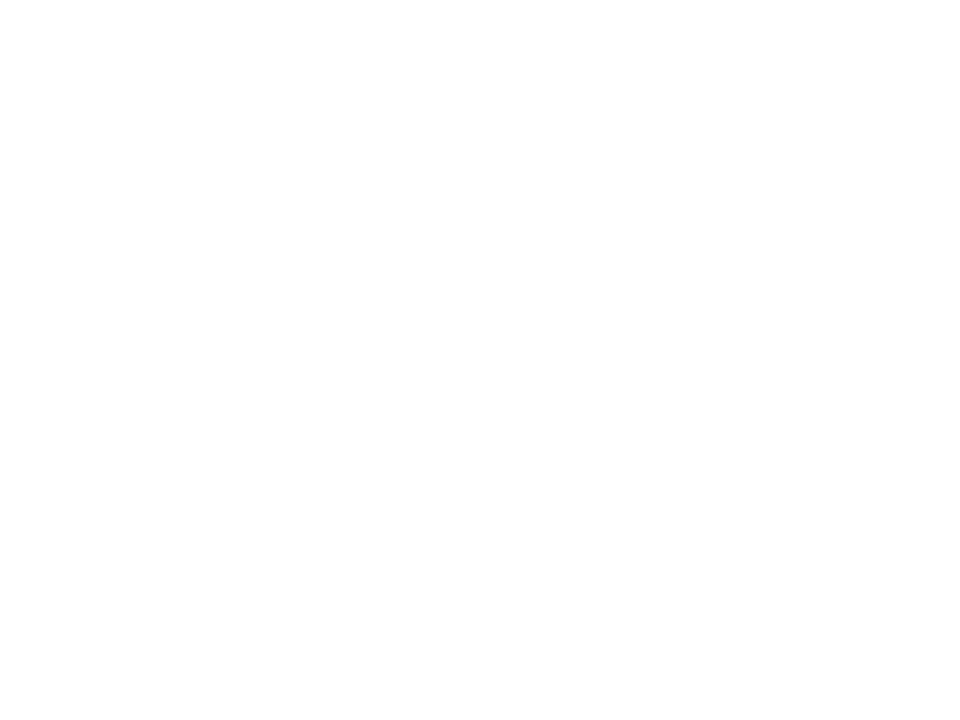

<AxesSubplot:xlabel='yhat', ylabel='y'>

In [21]:
%matplotlib notebook
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

<IPython.core.display.Javascript object>


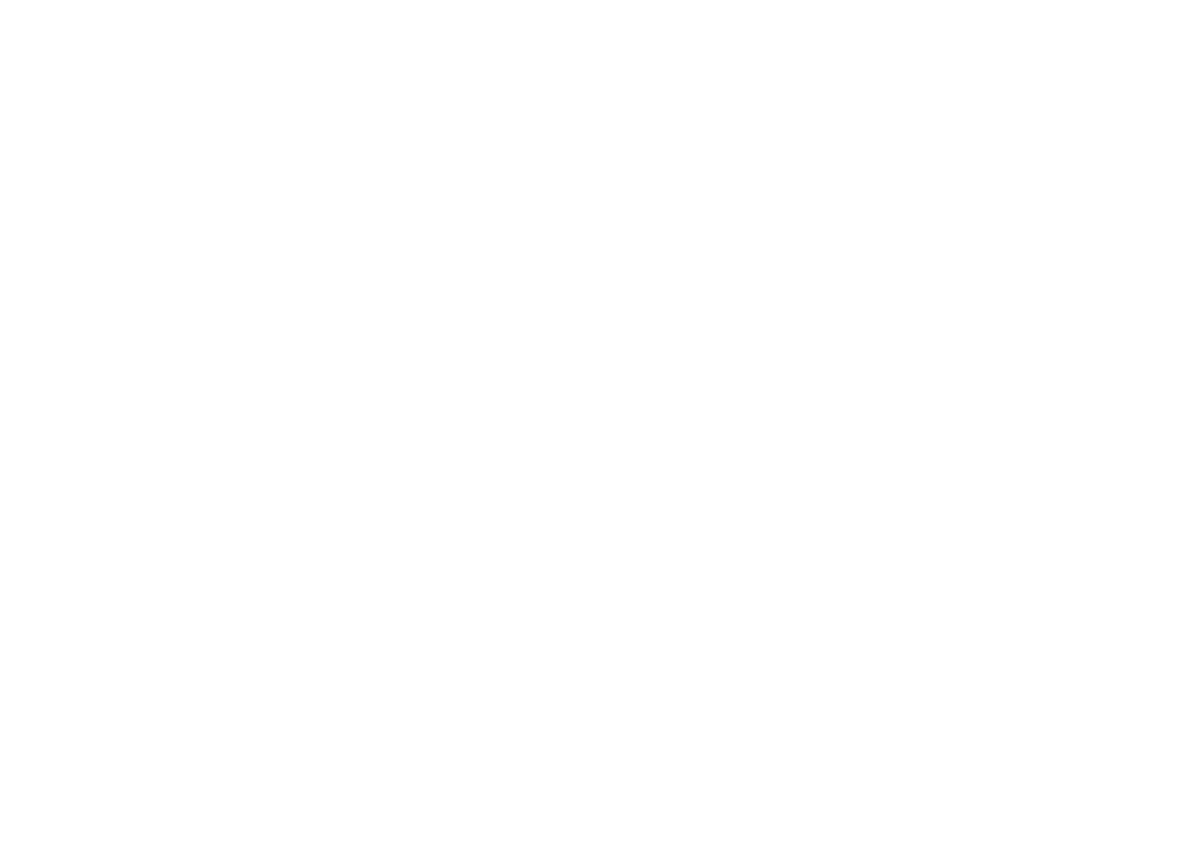

k,Males 0-1,Males 1-5,Males 5-10,Males 10-15,Males 15-20,Males 20-30,Males 30-50,Males 50-60,Males 60-100,Females 0-1,...,log HSize,logSugar,logRice,logYellow Corn,logWhite Corn,logRubber,logCoconut,logLand Area,Had Shocks,Constant
j,,,,,,,,,,,,,,,,,,,,,
Alcoholic drinks,0.211420,0.319409,0.068585,-0.284011,0.205210,0.099111,0.154595,-0.167062,-0.286902,-0.632918,...,-0.044192,0.000015,0.008802,0.010752,-0.030307,-0.018640,0.066784,0.228662,0.110355,-0.416642
Ampalaya,0.243134,0.428704,0.376099,0.355313,0.325800,0.326627,0.184713,0.231794,0.155713,-0.540194,...,-2.025655,0.018607,0.024658,0.003451,0.065277,-0.039064,0.013007,0.115329,0.056643,1.321389
Atsal,0.037141,0.177709,0.326849,-0.039619,0.151963,0.130189,0.062969,0.522491,0.145574,-0.396149,...,-0.478112,0.031329,0.021162,0.076356,-0.018286,-0.000766,0.043849,0.095464,-0.451711,0.106198
Bagoong,0.268694,0.162427,0.068400,-0.032739,0.085529,0.090474,0.076490,0.300520,0.188829,-0.402859,...,0.109144,0.013736,-0.004379,0.000859,-0.000107,-0.003674,0.064823,-0.046811,-0.061927,-0.650908
Banana,0.098976,0.187982,0.417660,0.266557,-0.005976,0.011891,-0.144589,0.477450,0.432842,-0.043951,...,-0.751432,0.032916,-0.001507,0.041125,0.003918,0.012310,0.025566,0.175151,-0.093327,0.069995
Beef,-0.472945,-0.000274,0.176368,0.013105,-0.084023,-0.013525,0.161867,0.491694,0.011705,-0.663709,...,0.196950,0.040961,0.009770,0.021806,0.019627,-0.011918,0.025201,0.214885,-0.638935,-0.480056
Calamansi,-0.106094,-0.089183,0.358085,0.301803,0.213628,0.024640,0.025076,-0.517319,0.001109,-0.061480,...,-1.001994,0.058421,0.046930,0.034540,0.102630,0.039632,-0.074924,0.089471,-0.131318,0.395953
Carrots,0.039727,0.155762,-0.185133,0.074996,0.151806,-0.080362,-0.008389,-0.201242,0.007750,-0.611269,...,-0.372653,-0.019779,0.045970,-0.002045,-0.000290,-0.020192,0.057481,0.107493,-0.075853,-0.059706
Chicken,0.147379,-0.049861,0.423724,-0.109950,-0.104897,-0.049921,-0.068498,0.130306,-0.101140,-0.478120,...,0.826245,-0.000616,0.056901,0.014425,0.036194,-0.045394,0.029593,0.193354,-0.007721,-1.758819


In [22]:
result.get_beta().sort_values()
result.graph_beta()
result.gamma

In [23]:
unit_vals = x_hat / q
p = unit_vals.median(axis = 0)
# get predicted quantities
q_hat = x_hat / p
q_hat
# Drop missing columns
q_hat = q_hat.loc[:,q_hat.count()>0]
q_hat

,,,Alcoholic drinks,Ampalaya,Atsal,Bagoong,Banana,Beef,Calamansi,Carrots,Chicken,Coffee,...,"Sardines like youngstown, etc",Sea weed,Sitao,Soybean and other products,Squash,Sugar,Talong,Tomatoes,"Vetsin, MSG",Vinegar
i,t,m,,,,,,,,,,,,,,,,,,,,,
2,2003,Bukidnon,132.204877,247.840780,139.239973,131.478271,1414.154853,302.836583,625.755321,136.294197,638.273327,17.874644,...,167.156823,77.533243,593.313193,433.932938,466.159863,867.378065,1086.177410,504.179171,432.041242,18.864795
4,2003,Bukidnon,891.765199,411.815071,401.142094,354.342678,1357.366434,553.347370,193.039599,409.831576,782.137528,29.425821,...,380.855785,507.300292,325.729407,492.651412,1321.386999,879.394685,1257.423202,499.004143,482.214247,21.534320
6,2003,Bukidnon,1416.787726,885.948972,484.066556,409.375720,1676.822630,418.835347,683.034924,718.251140,1109.822282,25.159655,...,796.933954,813.911208,404.260912,473.339880,1347.915677,1237.310550,1859.482815,977.268098,564.326230,30.565023
12,2003,Bukidnon,1292.454299,649.481815,254.117246,652.890516,374.954575,265.509555,172.573130,321.807333,1873.544024,16.407231,...,364.306951,264.055296,295.575967,481.147864,647.560734,1106.223839,1114.461812,169.016185,864.277356,50.148896
14,2003,Bukidnon,229.750339,313.306280,45.565977,133.172923,406.411024,129.580467,200.666288,250.304553,484.966526,9.925055,...,129.794443,171.999372,184.971565,206.724548,389.085514,565.525660,513.227661,118.403570,317.316875,14.369609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,2003,Bukidnon,698.816056,653.676925,263.436976,322.474723,1569.463447,938.530858,560.475021,208.524862,931.406262,25.637854,...,358.007413,224.998007,369.946524,536.169379,453.538898,1113.522657,1275.250004,396.037200,524.912630,13.540958
935,2003,Bukidnon,445.118384,623.646016,401.751149,316.955581,1037.893072,374.860624,340.321718,138.173905,1050.493439,33.213636,...,364.236229,324.289152,513.306997,544.097437,510.073418,1315.908385,981.546278,422.420334,726.648989,23.192581
936,2003,Bukidnon,738.859896,581.179530,280.339325,200.428176,850.579866,760.934621,365.008034,277.002094,392.299263,17.606077,...,185.669087,366.350958,348.016721,434.001513,723.715452,808.060444,1002.639657,739.714121,484.249827,12.753055


In [24]:
#fct = fct.dropna(how='all')
#print(fct)
use = fct.index.intersection(q_hat.columns)
nutrients = q_hat[use]@fct.loc[use,:]
#print(fct.loc[use,:])
# average household-level nutritional content
nutrients.mean()/365

n
calorie     13908.547300
protein       403.588637
fat           187.975107
carbo        2657.678253
fiber          47.815204
ash            22.773631
calcium      1283.381055
phos         5400.103857
iron           29.318092
retinol       101.399039
carotene      615.390129
thiamine        3.696749
riboflav        1.847744
niacin         77.673753
ascorbic      119.350324
edpor           0.000000
blufct          0.000000
dtype: float64

In [25]:
nutrients/365

,,n,calorie,protein,fat,carbo,fiber,ash,calcium,phos,iron,retinol,carotene,thiamine,riboflav,niacin,ascorbic,edpor,blufct
i,t,m,,,,,,,,,,,,,,,,,
2,2003,Bukidnon,25714.356277,650.179410,340.199739,5021.882860,75.127153,33.087735,1321.360066,8774.840266,29.861843,136.859741,660.668337,6.641977,2.241170,121.164313,155.853444,0.0,0.0
4,2003,Bukidnon,25162.272082,675.134172,263.524368,5037.288478,84.578764,42.100376,2278.614478,9017.418706,58.301000,131.021393,1045.885516,6.753822,2.927047,130.834204,202.346333,0.0,0.0
6,2003,Bukidnon,22510.285821,652.457632,305.405693,4315.003670,129.707622,51.140582,3342.577041,8873.685647,78.630470,172.490249,1628.451483,6.200629,3.876690,134.627197,330.010239,0.0,0.0
12,2003,Bukidnon,13241.426304,575.128735,220.373793,2237.641244,73.540321,28.584719,1806.130061,7302.356113,37.925533,179.907043,515.811829,3.968896,2.967124,117.904102,171.955356,0.0,0.0
14,2003,Bukidnon,11047.931938,288.180242,127.501658,2193.035157,34.194866,17.143795,866.710657,3793.827292,21.339258,48.942391,353.121902,2.859453,1.088795,56.944462,75.332676,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,2003,Bukidnon,20225.511304,654.408079,327.164505,3674.766681,73.031903,34.355435,1883.490872,8583.819749,42.008253,182.145319,756.770613,5.444992,3.408967,126.521232,185.966197,0.0,0.0
935,2003,Bukidnon,21202.492559,630.369540,292.156519,4023.340481,88.840474,35.374583,1939.543180,8283.571267,44.668762,156.438120,704.014772,5.557795,2.996905,121.108935,194.242726,0.0,0.0
936,2003,Bukidnon,16146.713151,468.737301,239.567440,3041.572851,53.373207,28.093176,1741.039460,6244.079119,42.144460,137.595153,999.519172,4.320769,2.637362,88.603920,152.368374,0.0,0.0


In [26]:
avg_hsize = np.mean(np.exp(d_copy['log HSize']))
# individual level
nutrients.mean()/365/avg_hsize

n
calorie     2060.525526
protein       59.790909
fat           27.848164
carbo        393.730112
fiber          7.083734
ash            3.373871
calcium      190.130527
phos         800.015386
iron           4.343421
retinol       15.022080
carotene      91.168908
thiamine       0.547666
riboflav       0.273740
niacin        11.507223
ascorbic      17.681529
edpor          0.000000
blufct         0.000000
dtype: float64

In [27]:
d_copy2

,,k,Males 0-1,Males 1-5,Males 5-10,Males 10-15,Males 15-20,Males 20-30,Males 30-50,Males 50-60,Males 60-100,Females 0-1,...,Females 60-100,log HSize,logSugar,logRice,logYellow Corn,logWhite Corn,logRubber,logCoconut,logLand Area,Had Shocks
i,t,m,,,,,,,,,,,,,,,,,,,,,
2,2003,Bukidnon,0,0,1,1,0,1,0,0,1,1,...,1,2.397895,12.254868,0.0,0.000000,0.000000,0.0,0.000000,1.446919,0
4,2003,Bukidnon,0,0,0,0,1,1,0,1,0,0,...,0,1.791759,0.000000,0.0,7.069874,0.000000,0.0,0.000000,1.386294,1
6,2003,Bukidnon,0,0,0,0,2,0,2,0,0,0,...,1,2.197225,0.000000,0.0,8.987947,0.000000,0.0,0.000000,1.098612,1
12,2003,Bukidnon,1,0,0,0,0,3,4,0,1,0,...,1,2.564949,0.000000,0.0,5.525453,5.525453,0.0,6.347389,0.009950,1
14,2003,Bukidnon,0,0,0,0,0,1,2,0,1,0,...,1,2.197225,0.000000,0.0,0.000000,7.496097,0.0,0.000000,0.693147,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,2003,Bukidnon,0,1,2,1,0,0,1,0,0,0,...,0,1.945910,10.778977,0.0,0.000000,0.000000,0.0,0.000000,0.916291,1
935,2003,Bukidnon,0,0,1,0,0,0,1,0,0,0,...,0,1.609438,11.759793,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1
936,2003,Bukidnon,0,1,0,0,0,1,0,0,0,0,...,0,1.386294,12.328295,0.0,0.000000,0.000000,0.0,0.000000,1.098612,0


In [28]:
d_copy2 = d_copy2[rdi.columns.tolist()]

hh_rdi = d_copy2@rdi.T

hh_rdi

,,Nutrition,calorie,protein,fiber,calcium,carbo,iron,niacin,phos,riboflav,thiamine,retinol,ascorbic
i,t,m,,,,,,,,,,,,
2,2003,Bukidnon,21030.0,595.0,224.0,9250.0,14301.05,212.0,141.0,10010.0,11.3,11.0,4950.0,636.0
4,2003,Bukidnon,14220.0,391.0,136.0,5500.0,9634.70,121.0,90.0,6400.0,7.3,7.0,3100.0,420.0
6,2003,Bukidnon,19310.0,528.0,196.0,7500.0,12774.00,173.0,127.0,7750.0,9.9,9.5,4364.0,557.0
12,2003,Bukidnon,29300.0,816.0,297.0,10800.0,19946.50,218.0,190.0,11610.0,15.9,15.1,6850.0,910.0
14,2003,Bukidnon,19240.0,565.0,221.0,7300.0,13034.30,185.0,134.0,7400.0,10.9,10.5,4700.0,650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,2003,Bukidnon,13020.0,352.0,122.0,5450.0,8537.05,102.0,79.0,5400.0,6.3,6.1,3050.0,335.0
935,2003,Bukidnon,9080.0,227.0,90.0,3850.0,6170.35,68.0,57.0,3450.0,4.1,4.0,1928.0,224.0
936,2003,Bukidnon,7560.0,191.0,66.0,3100.0,5262.85,59.0,44.0,3500.0,3.6,3.5,1664.0,192.0


In [29]:
# Match up nutrient names
use = nutrients.columns.intersection(hh_rdi.columns)
nutrient_ratio = (nutrients[use]/365/hh_rdi[use])

# ratio of actual household nutrients to recommended household nutrients
# >1 means household is above recommended level of a particular nutrient
# < 1 means household is insufficient in a particular nutrient
nutrient_ratio

,,n,calorie,protein,carbo,fiber,calcium,phos,iron,retinol,thiamine,riboflav,niacin,ascorbic
i,t,m,,,,,,,,,,,,
2,2003,Bukidnon,1.222746,1.092739,0.351155,0.335389,0.142850,0.876607,0.140858,0.027648,0.603816,0.198334,0.859321,0.245053
4,2003,Bukidnon,1.769499,1.726686,0.522828,0.621903,0.414294,1.408972,0.481826,0.042265,0.964832,0.400965,1.453713,0.481777
6,2003,Bukidnon,1.165732,1.235715,0.337796,0.661774,0.445677,1.144992,0.454511,0.039526,0.652698,0.391585,1.060057,0.592478
12,2003,Bukidnon,0.451926,0.704815,0.112182,0.247611,0.167234,0.628971,0.173970,0.026264,0.262841,0.186612,0.620548,0.188962
14,2003,Bukidnon,0.574217,0.510054,0.168251,0.154728,0.118727,0.512679,0.115347,0.010413,0.272329,0.099889,0.424959,0.115896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,2003,Bukidnon,1.553419,1.859114,0.430449,0.598622,0.345595,1.589596,0.411846,0.059720,0.892622,0.541106,1.601535,0.555123
935,2003,Bukidnon,2.335076,2.776958,0.652044,0.987116,0.503777,2.401035,0.656894,0.081140,1.389449,0.730953,2.124718,0.867155
936,2003,Bukidnon,2.135809,2.454122,0.577933,0.808685,0.561626,1.784023,0.714313,0.082689,1.234505,0.732601,2.013725,0.793585


<IPython.core.display.Javascript object>


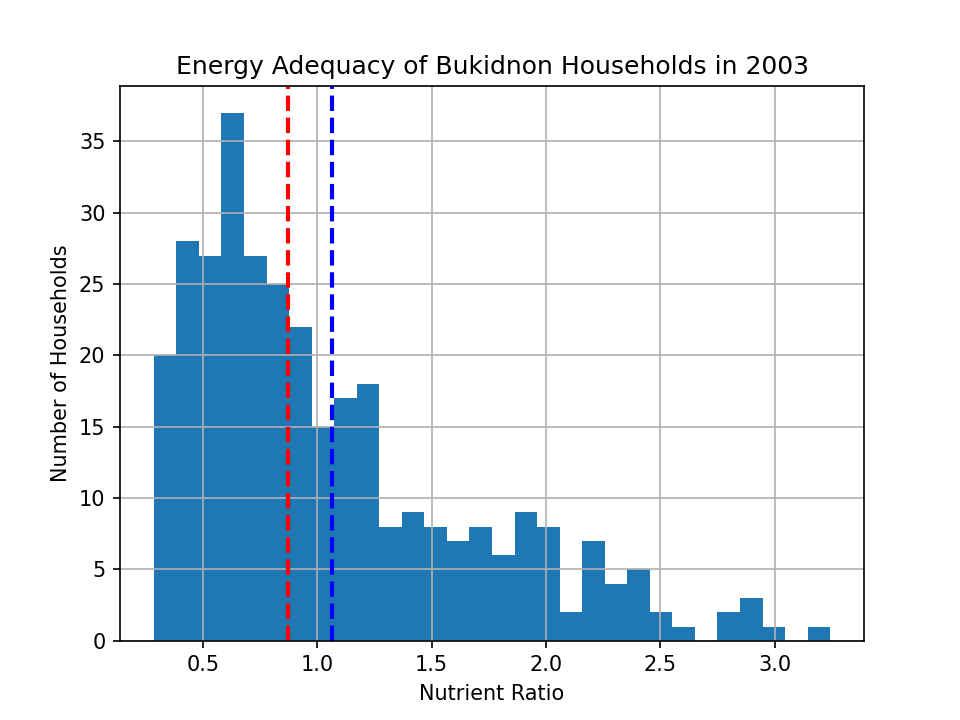

Text(0, 0.5, 'Number of Households')

In [39]:
# overall 
%matplotlib notebook
nutrient_ratio['calorie'].hist(bins=30)
# blue line is mean, red line is median
plt.axvline(nutrient_ratio['calorie'].mean(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(nutrient_ratio['calorie'].median(), color='r', linestyle='dashed', linewidth=2)
plt.title("Energy Adequacy of Bukidnon Households in 2003")
plt.xlabel('Nutrient Ratio') 
plt.ylabel('Number of Households') 

<IPython.core.display.Javascript object>


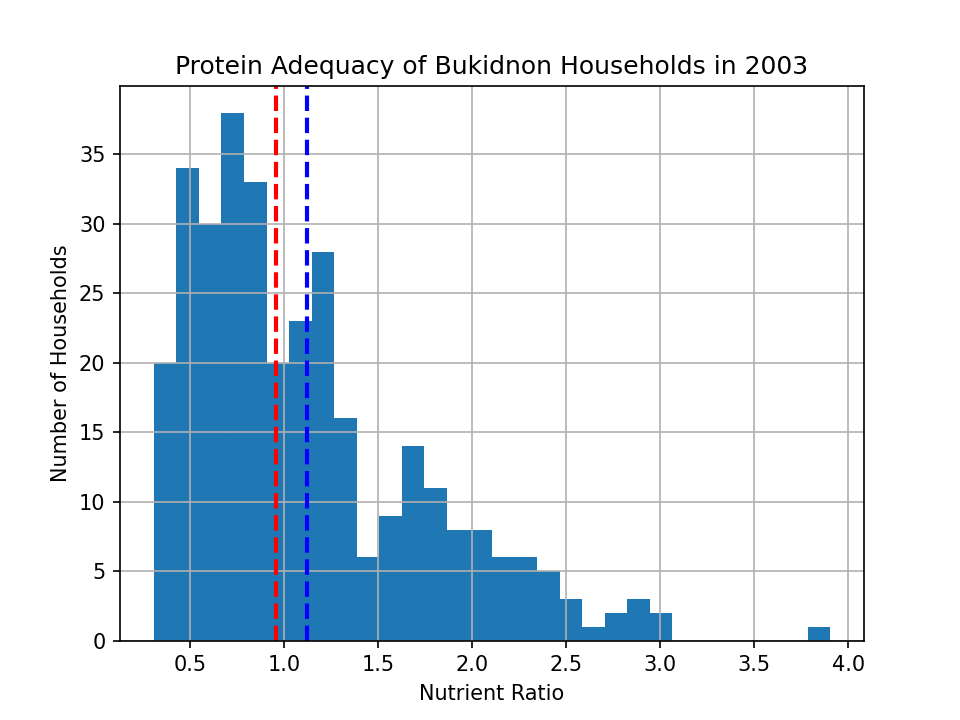

Text(0, 0.5, 'Number of Households')

In [40]:
%matplotlib notebook
nutrient_ratio['protein'].hist(bins=30) 
plt.axvline(nutrient_ratio['protein'].mean(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(nutrient_ratio['protein'].median(), color='r', linestyle='dashed', linewidth=2)
plt.title("Protein Adequacy of Bukidnon Households in 2003")
plt.xlabel('Nutrient Ratio') 
plt.ylabel('Number of Households') 

In [32]:
sugar = d_copy3.index[d_copy3['logSugar'] > 0].tolist()
nosugar = d_copy3.index[d_copy3['logSugar'] == 0].tolist()
rice = d_copy3.index[d_copy3['logRice'] > 0].tolist()
norice = d_copy3.index[d_copy3['logRice'] == 0].tolist()
rubber = d_copy3.index[d_copy3['logRubber'] > 0].tolist()
norubber = d_copy3.index[d_copy3['logRubber'] == 0].tolist()

<IPython.core.display.Javascript object>


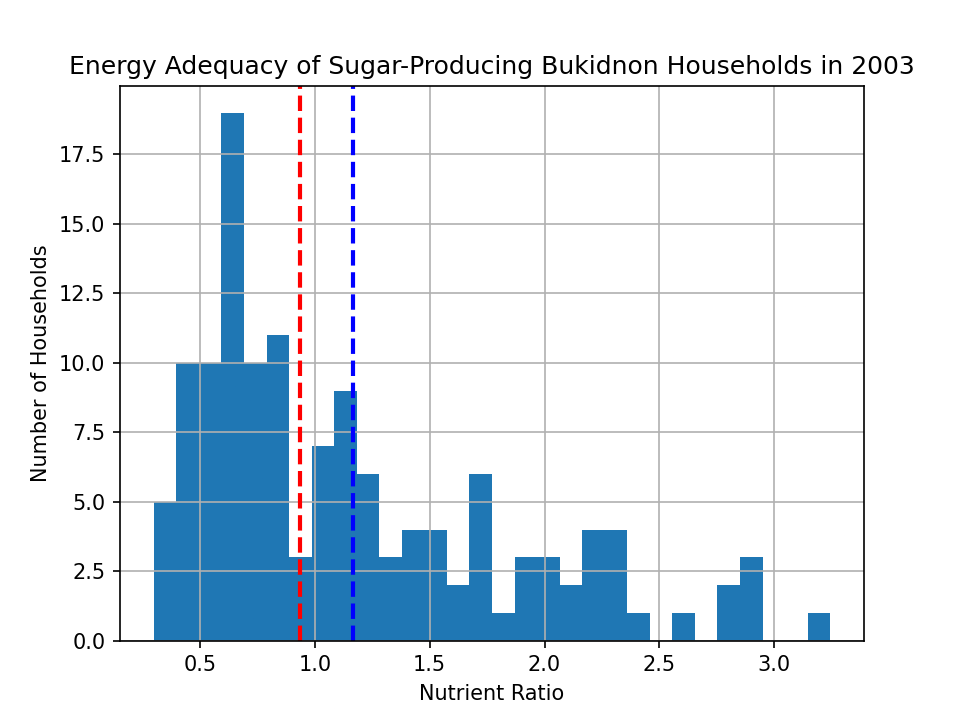

Text(0, 0.5, 'Number of Households')

In [41]:
%matplotlib notebook
nutrient_ratio.loc[sugar]['calorie'].hist(bins=30)
plt.axvline(nutrient_ratio.loc[sugar]['calorie'].mean(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(nutrient_ratio.loc[sugar]['calorie'].median(), color='r', linestyle='dashed', linewidth=2)

plt.title("Energy Adequacy of Sugar-Producing Bukidnon Households in 2003")
plt.xlabel('Nutrient Ratio') 
plt.ylabel('Number of Households') 
 

<IPython.core.display.Javascript object>


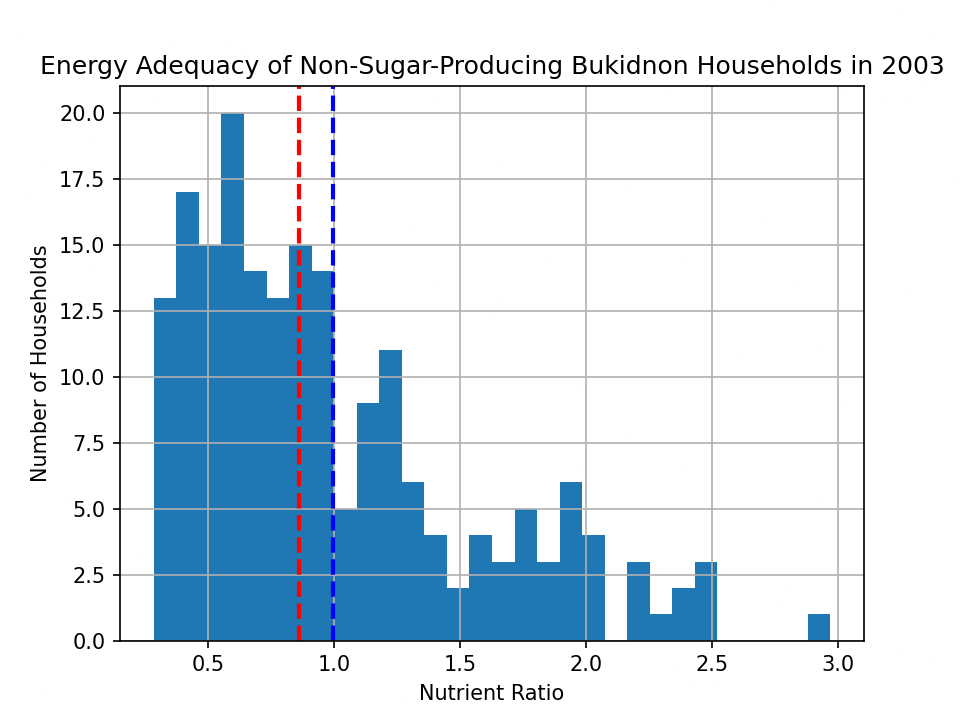

Text(0, 0.5, 'Number of Households')

In [42]:
%matplotlib notebook
nutrient_ratio.loc[nosugar]['calorie'].hist(bins=30)
plt.axvline(nutrient_ratio.loc[nosugar]['calorie'].mean(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(nutrient_ratio.loc[nosugar]['calorie'].median(), color='r', linestyle='dashed', linewidth=2)

plt.title("Energy Adequacy of Non-Sugar-Producing Bukidnon Households in 2003")
plt.xlabel('Nutrient Ratio') 
plt.ylabel('Number of Households') 

<IPython.core.display.Javascript object>


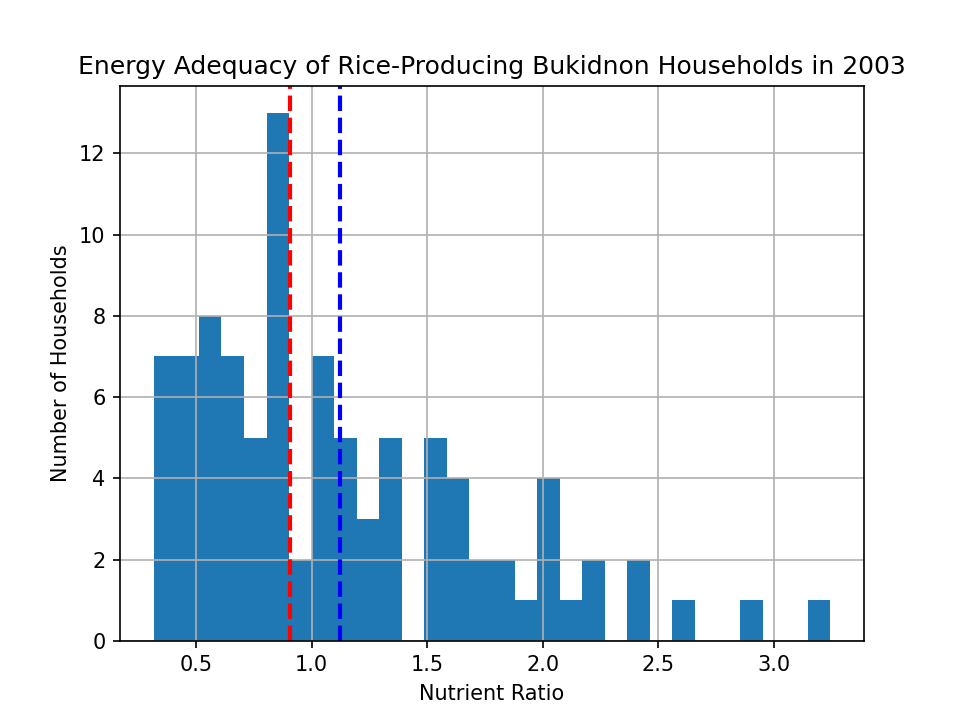

Text(0, 0.5, 'Number of Households')

In [43]:
%matplotlib notebook
nutrient_ratio.loc[rice]['calorie'].hist(bins=30)
plt.axvline(nutrient_ratio.loc[rice]['calorie'].mean(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(nutrient_ratio.loc[rice]['calorie'].median(), color='r', linestyle='dashed', linewidth=2)

plt.title("Energy Adequacy of Rice-Producing Bukidnon Households in 2003")
plt.xlabel('Nutrient Ratio') 
plt.ylabel('Number of Households') 

<IPython.core.display.Javascript object>


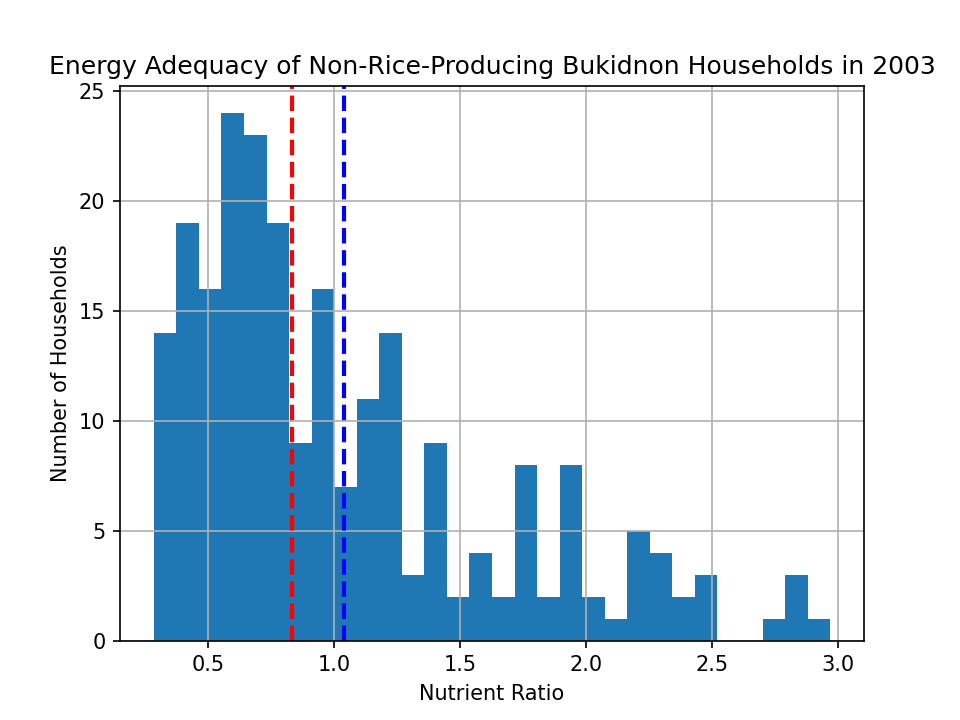

Text(0, 0.5, 'Number of Households')

In [44]:
%matplotlib notebook
nutrient_ratio.loc[norice]['calorie'].hist(bins=30)
plt.axvline(nutrient_ratio.loc[norice]['calorie'].mean(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(nutrient_ratio.loc[norice]['calorie'].median(), color='r', linestyle='dashed', linewidth=2)

plt.title("Energy Adequacy of Non-Rice-Producing Bukidnon Households in 2003")
plt.xlabel('Nutrient Ratio') 
plt.ylabel('Number of Households') 

<IPython.core.display.Javascript object>


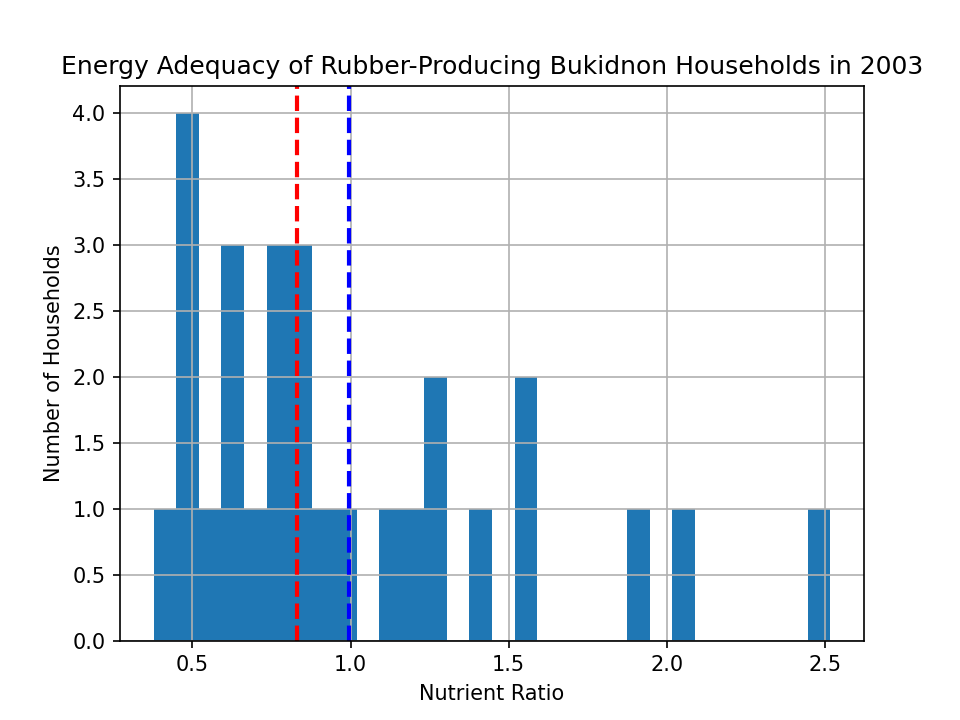

Text(0, 0.5, 'Number of Households')

In [45]:
%matplotlib notebook
nutrient_ratio.loc[rubber]['calorie'].hist(bins=30)
plt.axvline(nutrient_ratio.loc[rubber]['calorie'].mean(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(nutrient_ratio.loc[rubber]['calorie'].median(), color='r', linestyle='dashed', linewidth=2)

plt.title("Energy Adequacy of Rubber-Producing Bukidnon Households in 2003")
plt.xlabel('Nutrient Ratio') 
plt.ylabel('Number of Households') 

<IPython.core.display.Javascript object>


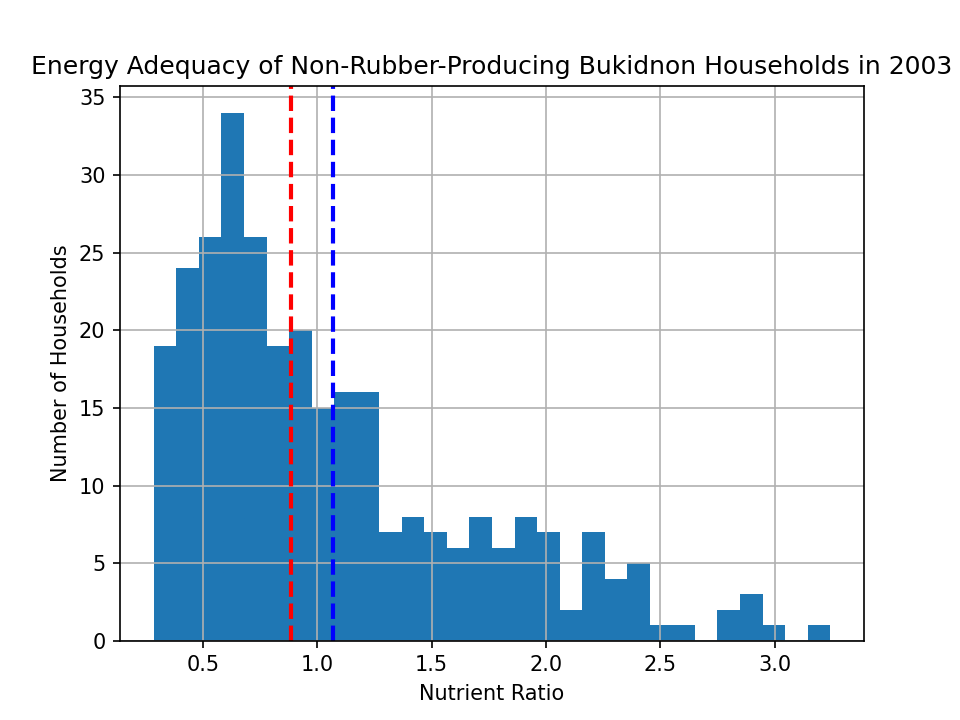

Text(0, 0.5, 'Number of Households')

In [38]:
%matplotlib notebook
nutrient_ratio.loc[norubber]['calorie'].hist(bins=30)
plt.axvline(nutrient_ratio.loc[norubber]['calorie'].mean(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(nutrient_ratio.loc[norubber]['calorie'].median(), color='r', linestyle='dashed', linewidth=2)

plt.title("Energy Adequacy of Non-Rubber-Producing Bukidnon Households in 2003")
plt.xlabel('Nutrient Ratio') 
plt.ylabel('Number of Households') 